##### basedon sample by The TensorFlow Hub Authors.


# Classify text with BERT

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Preprocessing
- Build model by combining BERT with a classifier
- Train model, fine-tuning BERT as part of that
- Save model and use it to classify sentences

## About BERT

BERT: Bidirectional Encoder Representation from Transformers.

Machine learning technique for NLP pre-training, developed by Google. Google has been using BERT to better understand user searches.

BERT has two pre-trained types: BERT-base and BERT-large.

It is a bidirectional model. It learns from left and right side of token's context during training.

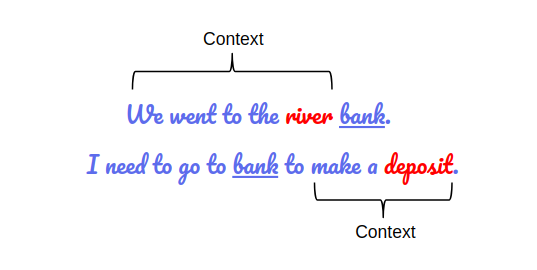




BERT uses several types of embeddings:
- Position embeddings: position of word in sentence
- Segment Embeddings: sentence pairs as inputs to optimize context calculation
- Token Embeddings: embeddings learned from WordPiece token vocabulary

Input representation is built by summing the associated position, segment, token embeddings.

## Setup




In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 2.6MB 12.4MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 849kB 14.3MB/s 
     |████████████████████████████████| 36.7MB 80kB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 1.1MB 44.2MB/s 
     |████████████████████████████████| 358kB 44.9MB/s 
     |████████████████████████████████| 174kB 59.8MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from keras.datasets import imdb
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
tf.get_logger().setLevel('ERROR')

## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.



In [4]:
#Download the IMDB dataset using TFDS.

#dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
#class_names = info.features['label'].names
#train_ds, test_ds = dataset['train'], dataset['test']

In [5]:
#Download the IMDB dataset using TFDS and split: train, test, validation datasets
splits, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True,
split=['train+test[:80]','train+test[80:90]', 'train+test[90:]'])
(train_ds, val_ds, test_ds) = splits

class_names = info.features['label'].names

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5AN02/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5AN02/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE5AN02/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
class_names

['neg', 'pos']

In [7]:
BUFFER_SIZE = 100
BATCH_SIZE = 64
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"Anything Park Chan-wook creates is guaranteed to be unique, brilliant, and very twisted at a minimum. Well, anything that isn't I'm a Cyborg at least. Park's newest film titled Thirst is a vampire romance-erotic-thriller-dark comedy-drama \xc2\x96 yes, that is a lot of adjectives \xc2\x97 inspired by the 19th century French novel by Emile Zola titled Therese Raquin. Park creates a uniquely Korean, and uniquely Park, vision of the vampire mythos and asks the audience to explore the dilemma of a Catholic priest discovering himself having a thirst for blood and the moral and spiritual crisis that would develop. Park delivers on the elements you would hope but definitely falls short of masterpiece quality like Oldboy or even that of Lady Vengeance. Heavily bloated with a narrative that often loses itself much less the audience, Thirst desperately needed another trip through the cutting room. It crawls when it should be running but luckily brings it back home before losing the aud

In [9]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]


## The preprocessing model

Preprocess: text-to-tensor.

** It is not necessary to run pure Python code outside TensorFlow model to preprocess text. 

Tasks such as stemming, low-frequency words, de-capitalisation are not necessary as they are performed by the preprocessing model.

BERT uses the Transformer model. It is an attention mechanism that learns contextual relations between words. BERT uses the Transformer encoder to generate a language model


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model

BERT outputs

In [12]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [13]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.9928098  -0.18611878  0.36673835  0.15233654  0.65504444
  0.96811545 -0.9486271   0.00216182 -0.9877731   0.0684272  -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894629   0.34321252  0.33231527 ...  0.21300802  0.7102081
  -0.05771121]
 [-0.28742063  0.31981063 -0.23018605 ...  0.58454984 -0.21329683
   0.7269203 ]
 [-0.66157085  0.68876755 -0.8743295  ...  0.10877217 -0.26173267
   0.47855398]
 ...
 [-0.22561112 -0.28925633 -0.07064408 ...  0.47566015  0.8327713
   0.4002535 ]
 [-0.29824248 -0.2747314  -0.05450488 ...  0.48849776  1.0955359
   0.18163344]
 [-0.4437826   0.0093073   0.07223728 ...  0.17290126  1.1833246
   0.07897978]]


The BERT models return a map with 3 important keys: 

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.

- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.

- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Fine-tuned Model definition


In [14]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Test the model



In [15]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.67001706]], shape=(1, 1), dtype=float32)


Model structure

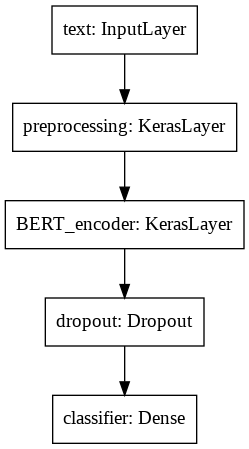

In [16]:
tf.keras.utils.plot_model(classifier_model)

## Model training

In [17]:
# Binary classification
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

(`init_lr`) - use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [18]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [19]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [20]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=3)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3
392/392 [==============================] - 218s 556ms/step - loss: 0.4881 - binary_accuracy: 0.7382 - val_loss: 0.3197 - val_binary_accuracy: 0.8567
Epoch 2/3
392/392 [==============================] - 216s 551ms/step - loss: 0.3293 - binary_accuracy: 0.8503 - val_loss: 0.2496 - val_binary_accuracy: 0.8974
Epoch 3/3
392/392 [==============================] - 215s 548ms/step - loss: 0.2742 - binary_accuracy: 0.8783 - val_loss: 0.2178 - val_binary_accuracy: 0.9105


In [21]:
#pred = classifier_model.predict(test_ds)

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [22]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

780/780 [==============================] - 129s 166ms/step - loss: 0.2795 - binary_accuracy: 0.8824
Loss: 0.27950847148895264
Accuracy: 0.8824484348297119


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


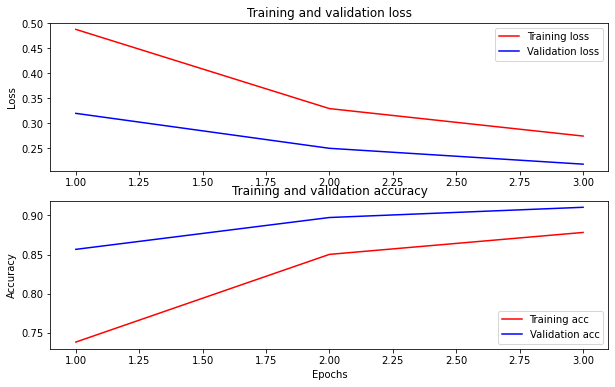

In [23]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export for inference

Now you just save your fine-tuned model for later use.

In [24]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [25]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [26]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997954
input: The movie was great!           : score: 0.984913
input: The movie was meh.             : score: 0.864082
input: The movie was okish.           : score: 0.050666
input: The movie was terrible...      : score: 0.009620

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997954
input: The movie was great!           : score: 0.984913
input: The movie was meh.             : score: 0.864082
input: The movie was okish.           : score: 0.050666
input: The movie was terrible...      : score: 0.009620



In [27]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.997954
input: The movie was great!           : score: 0.984913
input: The movie was meh.             : score: 0.864082
input: The movie was okish.           : score: 0.050666
input: The movie was terrible...      : score: 0.009620

